# In this note book the following steps are taken:
1. Remove highly correlated attributes
2. Find the best hyper parameters for estimator
3. Find the most important features by tunned random forest
4. Find f1 score of the tunned full model
5. Find best hyper parameter of model with selected features
6. Find f1 score of the tuned seleccted model
7. Compare the two f1 scores

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV,RFE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
import numpy as np
from sklearn.metrics import make_scorer
f1_score = make_scorer(f1_score)

In [9]:
#import data
Data=pd.read_csv("Calgary-Transfomed-Data-BS-NoBreak - Copy.csv")

In [10]:
X = Data.iloc[:,:-1]
y = Data.iloc[:,-1]

In [11]:
#split test and training set. 
np.random.seed(60)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10,
                                                    random_state = 1000)

In [12]:
#Define estimator and model
classifiers = {}
classifiers.update({"Random Forest": RandomForestClassifier(random_state=1000)})

In [13]:
#Define range of hyperparameters for estimator
np.random.seed(60)
parameters = {}
parameters.update({"Random Forest": { "classifier__n_estimators": [100,105,110,115,120,125,130,135,140,145,150,155,160,170,180,190,200],
                                   # "classifier__n_estimators": [2,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200],
                                    #"classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                     "classifier__max_depth" : [4,6,8,10,11,12,13,14,15,16,17,18,19,20,22],
                                    #"classifier__max_depth" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
                                    "classifier__criterion" :["gini", "entropy"]
                                    
}})

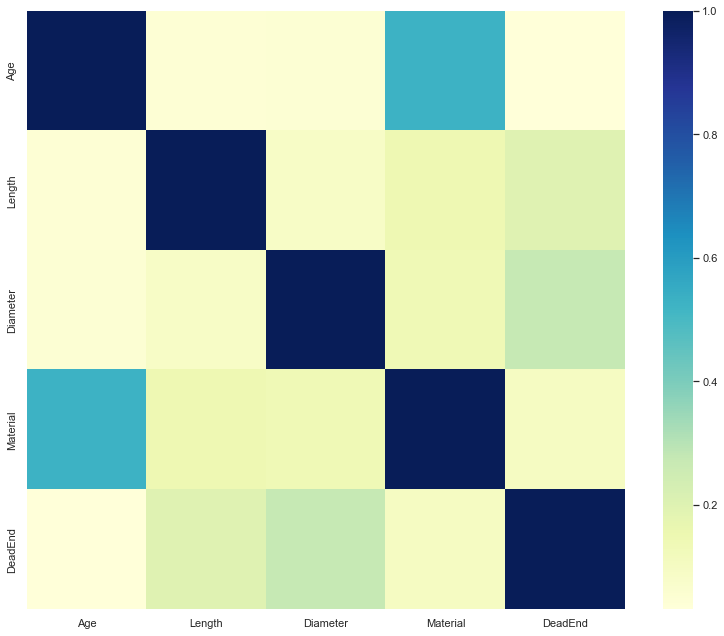

In [14]:
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)

In [15]:
X_train

,Age,Length,Diameter,Material,DeadEnd
31820,48,86.5820,300,6.782511,1.277752
41699,49,9.0113,1950,7.062329,1.277752
20053,11,2.0000,250,3.178098,0.277752
36479,42,247.4447,150,6.782511,1.277752
60356,80,329.8404,150,8.041831,1.277752
...,...,...,...,...,...
48379,40,239.0365,300,6.782511,1.277752
3776,32,262.1976,200,3.178098,1.277752
6215,13,487.7812,200,3.178098,1.277752
4695,15,326.2373,200,3.178098,1.277752


In [16]:
FEATURE_IMPORTANCE = {"Random Forest"}
selected_classifier = "Random Forest"
classifier = classifiers[selected_classifier]

In [17]:
scaler = StandardScaler()
steps = [("scaler", scaler), ("classifier", classifier)]
pipeline = Pipeline(steps = steps)

In [18]:
#Define parameters that we want to use in gridsearch cv
param_grid = parameters[selected_classifier]

In [19]:
# Initialize GridSearch object for estimator
gscv = RandomizedSearchCV(pipeline, param_grid, cv = 3,  n_jobs= -1, verbose = 1, scoring = f1_score, n_iter=30)

In [20]:
# Fit gscv (Tunes estimator)
print(f"Now tuning {selected_classifier}. Go grab a beer or something.")
gscv.fit(X_train, np.ravel(y_train))  

Now tuning Random Forest. Go grab a beer or something.
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=1000))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'classifier__max_depth': [4, 6, 8, 10,
                                                                  11, 12, 13,
                                                                  14, 15, 16,
                                                                  17, 18, 19,
                                                                  20, 22],
                                        'classifier__max_features': ['auto',
                                                                     'sqrt',
             

In [21]:
#Getting the best hyperparameters
best_params = gscv.best_params_
best_params

{'classifier__n_estimators': 115,
 'classifier__max_features': 'auto',
 'classifier__max_depth': 17,
 'classifier__criterion': 'entropy'}

In [22]:
#Getting the best score of model
best_score = gscv.best_score_
best_score

0.9780110809005998

In [23]:
#Check overfitting of the estimator
from sklearn.model_selection import cross_val_score
mod = RandomForestClassifier(#class_weight= None,
 criterion= 'entropy',
 max_depth= 17,
 max_features= 'auto',
 n_estimators= 115 ,random_state=10000)

scores_test = cross_val_score(mod, X_test, y_test, scoring='f1', cv=5)

scores_test

array([0.97375469, 0.97579344, 0.96533333, 0.97109208, 0.97746781])

In [24]:
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=115,
                       random_state=1000)

In [25]:
#Find f1 score of the model with all features (Model is tuned for all features)
results={}
model=classifier.set_params(criterion= 'entropy',
 max_depth= 17,
 max_features= 'auto',
 n_estimators= 115 ,random_state=10000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
F1 = metrics.f1_score(y_test, y_pred)
results = {"classifier": model,
              "Best Parameters": best_params,
              "Training f1": best_score*100,
              "Test f1": F1*100}
results


{'classifier': RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=115,
                        random_state=10000),
 'Best Parameters': {'classifier__n_estimators': 115,
  'classifier__max_features': 'auto',
  'classifier__max_depth': 17,
  'classifier__criterion': 'entropy'},
 'Training f1': 97.80110809005998,
 'Test f1': 98.02913453299058}

In [26]:
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [27]:
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)
np.random.seed(60)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 5, step = 1, verbose = 1)

# Fit RFECV
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.


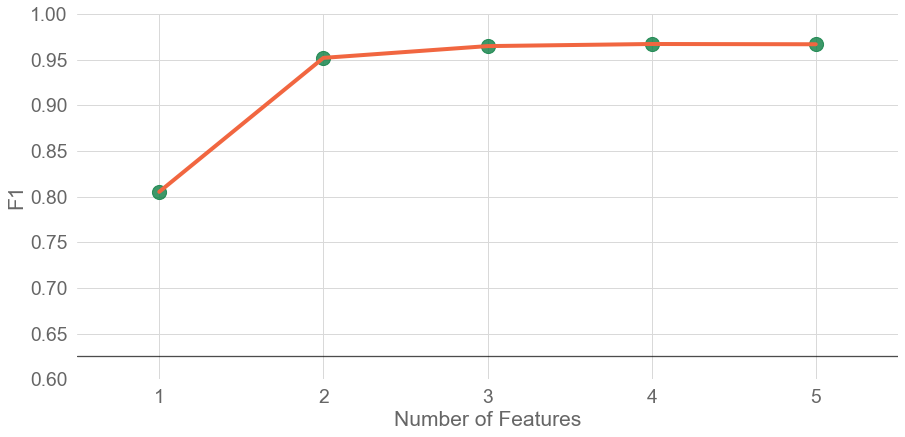

In [28]:
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "F1": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "F1", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["F1"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.60, 1)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.625, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

In [29]:
#Define new training and test set based based on selected features by RFECV
X_train_rfecv = X_train[selected_features]
X_test_rfecv= X_test[selected_features]

In [30]:
np.random.seed(60)
classifier.fit(X_train_rfecv, np.ravel(y_train))

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=115,
                       random_state=10000)

In [31]:
#Finding important features
np.random.seed(60)
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)
feature_importance

,Feature Label,Feature Importance
0,Age,0.344948
3,Material,0.337532
1,Length,0.252347
2,Diameter,0.065173


In [32]:
# Initialize GridSearch object for model with selected features
np.random.seed(60)
gscv = RandomizedSearchCV(pipeline, param_grid, cv = 3,  n_jobs= -1, verbose = 1, scoring = f1_score, n_iter=30)

In [33]:
#Tuning random forest classifier with selected features 
np.random.seed(60)
gscv.fit(X_train_rfecv,y_train) 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(criterion='entropy',
                                                                     max_depth=17,
                                                                     n_estimators=115,
                                                                     random_state=10000))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'classifier__max_depth': [4, 6, 8, 10,
                                                                  11, 12, 13,
                                                                  14, 15, 16,
                                                           

In [34]:
#Getting the best parameters of model with selected features
best_params = gscv.best_params_
best_params

{'classifier__n_estimators': 100,
 'classifier__max_features': 'auto',
 'classifier__max_depth': 16,
 'classifier__criterion': 'entropy'}

In [35]:
#Getting the score of model with selected features
best_score = gscv.best_score_
best_score

0.9780190620521813

In [36]:
#Check overfitting of the  tuned model with selected features 
from sklearn.model_selection import cross_val_score
mod = RandomForestClassifier(#class_weight= None,
 criterion= 'entropy',
 max_depth= 16,
 max_features= 'auto',
 n_estimators= 100 ,random_state=10000)

scores_test = cross_val_score(mod, X_test_rfecv, y_test, scoring='f1', cv=5)

scores_test

array([0.97216274, 0.97364174, 0.96757044, 0.96946974, 0.97746781])

In [37]:
results={}
model=classifier.set_params(criterion= 'entropy',
 max_depth= 16,
 max_features= 'auto',
 n_estimators= 100 ,random_state=10000)
scores_test = cross_val_score(mod, X_test_rfecv, y_test, scoring='f1', cv=5)
model.fit(X_train_rfecv,y_train)
y_pred = model.predict(X_test_rfecv)
F1 = metrics.f1_score(y_test, y_pred)
results = {"classifier": model,
              "Best Parameters": best_params,
              "Training f1": best_score*100,
              "Test f1": F1*100}
results

{'classifier': RandomForestClassifier(criterion='entropy', max_depth=16, random_state=10000),
 'Best Parameters': {'classifier__n_estimators': 100,
  'classifier__max_features': 'auto',
  'classifier__max_depth': 16,
  'classifier__criterion': 'entropy'},
 'Training f1': 97.80190620521813,
 'Test f1': 98.04173354735153}